In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
import json
from tqdm.notebook import tqdm

from calculating_stock_features import CalculatingStockFeatures

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.metrics import silhouette_score,homogeneity_score, v_measure_score,davies_bouldin_score,calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import KernelKMeans, TimeSeriesKMeans, KShape
import pickle

import scipy
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

In [194]:
import warnings
warnings.filterwarnings('ignore')

In [195]:
with open('config/config.json', 'r') as file:
    config = json.load(file)

In [196]:
config

{'start_date': '2018-10-23',
 'end_date': '2022-10-23',
 'tickers_sectors_path': 'data/tickers_sectors.csv',
 'ticker_data_close': 'data/ticker_data_Close.csv',
 'ticker_data_sp500': 'data/ticker_data_SP500.csv',
 'ticker_data_volume': 'data/ticker_data_Volume.csv',
 'metrics_path': 'results/metrics_table.csv',
 'predictions_path': 'results/prediction_table.csv',
 'ticker_data_preprocessed': 'data/ticker_data_preprocessed.csv'}

# Loading&Preprocessing Data

In [323]:
df = pd.read_csv(config['ticker_data_close'], index_col=0)
df_index = pd.read_csv(config['ticker_data_sp500'], index_col=0)
df_na = df.isna().sum() 
stocks_to_drop = df_na[df_na > 0].index.tolist()
df = df.drop(stocks_to_drop, axis=1)

In [205]:
df_s = pd.read_csv(config['ticker_data_preprocessed'], index_col=0)
df_s.head()

,2018-10-24,2018-10-25,2018-10-26,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-05,2018-11-06,...,2022-03-09,2022-03-10,2022-03-11,2022-03-14,2022-03-15,2022-03-16,2022-03-17,2022-03-18,2022-03-18.1,sector
A,-0.025506,0.024211,0.001917,-0.010362,0.025129,0.018070,0.006637,0.010886,-0.000303,0.001062,...,0.030467,0.008029,-0.029926,-0.020950,0.021163,0.036230,0.013482,0.016810,0.0,Healthcare
AAL,-0.063002,0.066908,0.002780,0.004313,0.063190,0.012118,0.036773,-0.001100,-0.016791,-0.015398,...,0.058475,-0.006993,-0.012676,0.016405,0.092632,0.057803,0.004857,0.012085,0.0,Industrials
AAP,-0.029213,0.025066,0.008457,0.001945,0.000607,-0.031582,0.023473,0.009113,0.000667,0.018049,...,0.021438,0.000195,-0.004099,-0.024059,0.025606,0.015910,0.003180,-0.008838,0.0,Consumer Cyclical
AAPL,-0.034302,0.021898,-0.015924,-0.018770,0.004994,0.026067,0.015352,-0.066331,-0.028388,0.010814,...,0.034997,-0.027186,-0.023909,-0.026562,0.029677,0.029015,0.006454,0.020919,0.0,Technology
ABBV,-0.042792,0.029215,-0.011501,0.007055,0.002827,-0.045839,0.030315,-0.008104,0.037959,0.013078,...,0.011485,0.002217,-0.000737,0.020395,0.024852,0.001091,0.016277,0.003846,0.0,Healthcare


In [203]:
df_sectors = pd.read_csv(config['tickers_sectors_path'], index_col=0)
df_sectors.head()

,ticker,sector
0,SPGI,Financial
1,MCO,Financial
2,CPRT,Industrials
3,EFX,Industrials
4,FLT,Technology


In [207]:
n_clusters_ = df_sectors['sector'].nunique()

df_predictions = pd.DataFrame(df_s['sector'].values, index=df_s.index, columns=['original'])
df_predictions['original_n'] = LabelEncoder().fit_transform(df_predictions['original'])
df_predictions.head()

,original,original_n
A,Healthcare,6
AAL,Industrials,7
AAP,Consumer Cyclical,2
AAPL,Technology,9
ABBV,Healthcare,6


In [213]:
ticks = set(df.T.index) & set(df_predictions.index)
df = df[list(ticks)]
df_predictions = df_predictions.loc[ticks]

483

# Calculating features

- + средняя доходность ср((pct_change))
- + медианная доходность
- + стандартное отклонение
- + доля дней с положительной доходностью от pct_change
- + просадки (хотя бы максимальная за период)
- + период восстановления (максимальный период восстановления от лок макс )
- + beta cov(stock, market) / var(market)
- + Alfa: R_s_mean = a + b * R_m_mean
- + Sharp: (R_s_mean - 0.03)/ std(R_s)
- + VaR: pct_change.quantile(0.05) = с вероятность 95 вы не просрете вот ету цифру
- + CAPM: безрисковая ставка + (R_m- безриск ставка) * B
- + IR: R_s_mean - R_m_mean/ std(R_s_mean - R_m_mean)
- + Coef of variation: std(pct_change)/ R_s_mean
- + CVAR price[price < Var].mean()
- + Просадка относительно входа: процентное изменение точки входа и максимального падения
- + Проскад относительно пика: процентное изменение точки пика и максимального падения
- + Количество дней после максимального падения
- + momentum price

In [215]:
df_features = CalculatingStockFeatures.calculate_features(df, df_index['^GSPC'])
df_features

,mean,median,std,glob_max_drawdown,loc_max_drawdown,loc_max_price,pct_days_of_profit_return,pct_days_after_max_drawdown,beta,alfa,sharp,VaR,CAPM,IR,variation_coef,CVaR,rel_drawdown,momentum,max_recovery_peiod
CERN,0.000405,0.000458,0.015987,0.713140,1.328861,1.359049,0.516537,0.030156,0.676142,7.755601e-07,-61.659461,-0.025569,0.009990,-0.042645,39.449582,-0.036310,0.713140,0.237957,59.0
IT,0.001073,0.002014,0.021609,0.666720,2.203284,2.720785,0.572957,0.455253,1.025108,4.600750e-04,-45.587558,-0.029548,0.000347,-0.034659,20.132940,-0.049598,0.666720,0.354174,308.0
DPZ,0.001077,0.000778,0.020469,1.025249,2.266503,3.018776,0.522374,0.479572,0.504888,7.751614e-04,-48.127412,-0.027228,0.015397,-0.028204,19.001753,-0.042829,1.000000,0.351735,17.0
EIX,0.000184,0.000405,0.020352,0.703083,0.703083,1.082055,0.512646,0.785019,0.782086,-2.836633e-04,-48.447001,-0.028038,0.006681,-0.033575,110.487744,-0.050061,0.703083,0.287180,331.0
FFIV,0.000621,0.001022,0.019569,0.682984,1.504827,1.868909,0.530156,0.460117,0.878754,9.505612e-05,-50.362653,-0.029323,0.004183,-0.037339,31.525154,-0.046222,0.682984,0.180905,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ORLY,0.001114,0.000873,0.018431,0.888550,2.530771,2.840969,0.530156,0.924125,0.865007,5.962416e-04,-53.447139,-0.023990,0.005013,-0.040169,16.548876,-0.041483,0.888550,0.284832,474.0
HPQ,0.000833,0.001952,0.023680,0.614916,1.635084,1.838649,0.541829,0.455253,1.176910,1.291638e-04,-41.610845,-0.034988,-0.004327,-0.032606,28.419825,-0.059906,0.614916,0.339196,253.0
HON,0.000474,0.000954,0.017407,0.704980,1.353622,1.589566,0.537938,0.457198,1.026255,-1.394765e-04,-56.627189,-0.026176,-0.000301,-0.055088,36.688120,-0.041690,0.704980,0.271552,2.0
TFX,0.000395,0.000863,0.020250,0.884505,1.136419,1.742433,0.524319,0.457198,0.960327,-1.792839e-04,-48.681680,-0.031527,0.001570,-0.037713,51.237628,-0.047829,0.884505,0.265386,340.0


In [216]:
df_features.describe()

,mean,median,std,glob_max_drawdown,loc_max_drawdown,loc_max_price,pct_days_of_profit_return,pct_days_after_max_drawdown,beta,alfa,sharp,VaR,CAPM,IR,variation_coef,CVaR,rel_drawdown,momentum,max_recovery_peiod
count,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,0.000682,0.000950,0.022388,0.677838,1.613708,2.285755,0.526279,0.462612,1.025938,0.000068,-46.767078,-0.031397,-0.000040,-0.035672,-28.702982,-0.051227,0.677329,0.332013,138.910973
std,0.000522,0.000648,0.006101,0.231842,2.315047,4.883903,0.020320,0.135481,0.278290,0.000505,10.707967,0.007984,0.008038,0.009479,1149.747659,0.012958,0.231111,0.115571,166.284508
min,-0.000695,-0.001361,0.012198,0.090745,0.090745,0.355370,0.371595,0.010700,0.273979,-0.001279,-80.841576,-0.066860,-0.026711,-0.060369,-18942.065353,-0.109404,0.090745,0.138291,1.000000
25%,0.000372,0.000568,0.018229,0.517591,0.956282,1.288766,0.513619,0.457198,0.837424,-0.000192,-54.057315,-0.035487,-0.004795,-0.041915,21.170796,-0.058211,0.517591,0.254818,3.000000
50%,0.000622,0.000963,0.020857,0.708253,1.391017,1.688382,0.526265,0.457198,1.021391,0.000046,-47.250726,-0.029756,0.000111,-0.036647,32.019276,-0.048020,0.708253,0.306851,53.000000
75%,0.000902,0.001318,0.025066,0.879393,1.880507,2.335487,0.539883,0.464008,1.199313,0.000301,-39.321254,-0.026081,0.005318,-0.028947,49.120520,-0.042437,0.879393,0.373488,276.500000
max,0.005230,0.003876,0.052172,1.026976,46.142310,102.976923,0.582685,0.986381,2.006925,0.004357,-18.802351,-0.018099,0.021856,-0.007031,4019.041345,-0.028217,1.000000,0.871229,634.000000


## Feature Extraction

DFT - Discrete Fourier Transformation
DWT - Discrete Welvet Transformation

## Дилетантское фурье преобразование ( получаем комплексные числа и убираем мнимую часть)

In [238]:
df_ts_features = df.T
df_ts_features

Date,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,...,2022-01-19,2022-01-20,2022-01-21,2022-01-24,2022-01-25,2022-01-26,2022-01-27,2022-01-28,2022-01-31,2022-02-01
CERN,68.570000,69.070000,69.010002,70.529999,70.589996,71.699997,72.349998,72.639999,72.900002,70.620003,...,91.769997,91.489998,91.699997,91.709999,91.370003,91.120003,91.379997,91.389999,91.199997,91.250000
IT,124.849998,125.190002,127.300003,129.339996,130.309998,128.949997,128.160004,129.610001,130.130005,130.039993,...,280.049988,278.730011,275.079987,287.029999,277.600006,278.820007,277.179993,287.600006,293.890015,295.739990
DPZ,186.940002,191.660004,197.289993,200.300003,203.610001,206.710007,200.089996,209.850006,211.149994,209.289993,...,469.390015,452.269989,434.809998,456.239990,436.359985,423.700012,429.579987,441.010010,454.649994,458.299988
EIX,63.250000,62.750000,62.290001,62.980000,64.199997,63.520000,62.840000,62.320000,61.419998,61.330002,...,63.500000,63.380001,62.980000,62.270000,61.770000,62.110001,61.500000,62.020000,62.790001,61.669998
FFIV,132.580002,134.039993,137.119995,136.179993,137.619995,137.839996,139.000000,139.770004,141.809998,140.520004,...,222.800003,226.789993,221.259995,226.669998,221.139999,202.490005,202.110001,199.509995,207.619995,205.960007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ORLY,249.259995,253.839996,257.679993,260.279999,260.000000,261.260010,258.450012,259.750000,258.600006,257.890015,...,659.590027,648.059998,635.919983,657.770020,646.369995,630.820007,634.669983,643.520020,651.750000,656.989990
HPQ,21.320000,21.370001,21.530001,21.750000,21.840000,21.809999,22.049999,22.410000,22.920000,22.879999,...,36.599998,36.110001,34.860001,35.619999,34.980000,35.230000,35.209999,36.299999,36.730000,37.459999
HON,147.323242,146.106018,148.080414,149.115540,148.310440,149.527679,150.562805,151.358307,152.460526,151.329559,...,210.729996,208.919998,205.100006,204.449997,202.300003,200.649994,200.649994,201.990005,204.479996,205.339996
TFX,254.729996,256.640015,254.009995,257.730011,258.679993,262.140015,257.920013,260.660004,263.179993,262.929993,...,332.859985,324.829987,323.200012,317.290009,304.420013,298.739990,295.559998,299.850006,310.190002,309.500000


In [239]:
def diletant_fourie(values=df_ts_features.values):

    X = scipy.fft.fft(values)

    all_array = []

    for i in range(len(X)):
         array = [int(a.real) for a in X[i]]
         all_array.append(array)
        
    return np.array(all_array)

In [240]:
X_fourie_1 = diletant_fourie(df_ts_features.values)

## Фурье преобразование по умной статье


<AxesSubplot:xlabel='Date'>

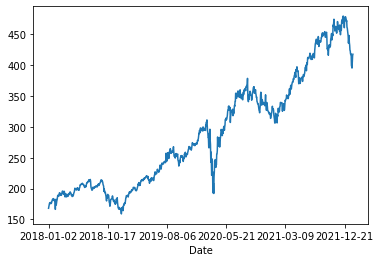

In [242]:
df['SPGI'].plot()

In [243]:
df['SPGI']

Date
2018-01-02    168.119995
2018-01-03    170.820007
2018-01-04    173.380005
2018-01-05    175.699997
2018-01-08    177.179993
                 ...    
2022-01-26    397.540009
2022-01-27    395.079987
2022-01-28    406.619995
2022-01-31    415.220001
2022-02-01    417.459991
Name: SPGI, Length: 1029, dtype: float64

1029


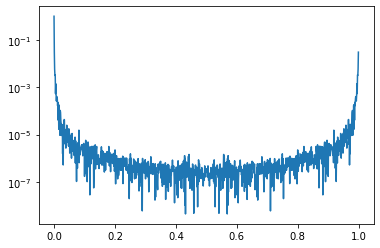

In [244]:
import numpy as np

x = list(range(len(df['SPGI'].index)))
y = df['SPGI'].values

# apply fast fourier transform and take absolute values
f=abs(np.fft.fft(y))

# get the list of frequencies
num=np.size(x)
freq = [i / num for i in list(range(num))]

# get the list of spectrums
spectrum=f.real*f.real+f.imag*f.imag
print(len(spectrum))
nspectrum=spectrum/spectrum[0]

# plot nspectrum per frequency, with a semilog scale on nspectrum
plt.semilogy(freq,nspectrum)

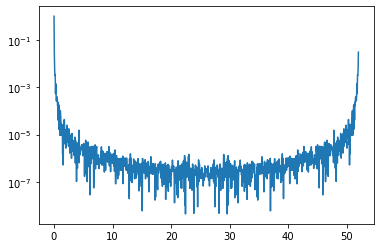

In [245]:
results = pd.DataFrame({'freq': freq, 'nspectrum': nspectrum})
results['period'] = results['freq'] / (1/52)
plt.semilogy(results['period'], results['nspectrum'])

([<matplotlib.axis.XTick at 0x2c1915864f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

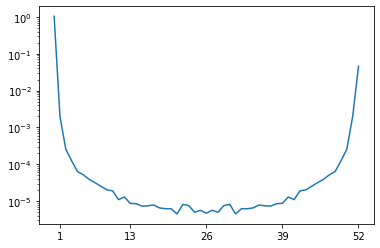

In [246]:
# improve the plot by convertint the data into grouped per week to avoid peaks
results['period_round'] = results['period'].round()
grouped_week = results.groupby('period_round')['nspectrum'].sum()
plt.semilogy(grouped_week.index, grouped_week)
plt.xticks([1, 13, 26, 39, 52])

In [247]:
transformed_X = []

for tick in df.columns:
    x = list(range(len(df[tick].index)))
    y = df[tick].values

    # apply fast fourier transform and take absolute values
    f=abs(np.fft.fft(y))

    # get the list of frequencies
    num=np.size(x)
    freq = [i / num for i in list(range(num))]

    # get the list of spectrums
    spectrum=f.real*f.real+f.imag*f.imag
    nspectrum=spectrum/spectrum[0]

    results = pd.DataFrame({'freq': freq, 'nspectrum': nspectrum})
    results['period'] = results['freq'] / (1/52)

    # improve the plot by convertint the data into grouped per week to avoid peaks
    results['period_round'] = results['period'].round()
    grouped_week = results.groupby('period_round')['nspectrum'].sum()

    transformed_X.append(grouped_week.values)

print(np.array(transformed_X).shape)

(483, 53)


In [248]:
X_fourie_2 = np.array(transformed_X)

In [26]:
train_all(np.array(transformed_X), all_models, all_params, grid_search=True, metrics=["calinski_harabasz", "davies_bouldin"])

,hyperparams,silhouette_score,calinski_harabasz,davies_bouldin
KMeans,"{'algorithm': 'auto', 'init': 'k-means++', 'n_...",0.571958,2472.330460,0.493923
AgglomerativeClustering,"{'affinity': 'manhattan', 'linkage': 'single',...",0.733656,272.566183,0.185191
GaussianMixture,"{'covariance_type': 'full', 'init_params': 'km...",0.567193,228.698087,0.588695


# ARIMA

идея: строим для каждого ряда акции модель ARIMA и коэффициенты модели берем как фичи

Смотрим на ряд, он должен быть стационарным

In [251]:
test_data = pd.DataFrame(df['SPGI'])
test_data.index = pd.to_datetime(test_data.index)

<AxesSubplot:xlabel='Date'>

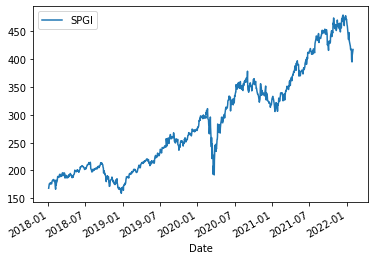

In [252]:
test_data.plot()

есть смысл перейти к недельному интервалу и среднему значению отгрузок на нем, это избавит нас от выбросов и уменьшит колебания нашего ряда

,SPGI
Date,
2018-01-07,"AxesSubplot(0.125,0.125;0.775x0.755)"
2018-01-14,"AxesSubplot(0.125,0.125;0.775x0.755)"
2018-01-21,"AxesSubplot(0.125,0.125;0.775x0.755)"
2018-01-28,"AxesSubplot(0.125,0.125;0.775x0.755)"
2018-02-04,"AxesSubplot(0.125,0.125;0.775x0.755)"
...,...
2022-01-09,"AxesSubplot(0.125,0.125;0.775x0.755)"
2022-01-16,"AxesSubplot(0.125,0.125;0.775x0.755)"
2022-01-23,"AxesSubplot(0.125,0.125;0.775x0.755)"


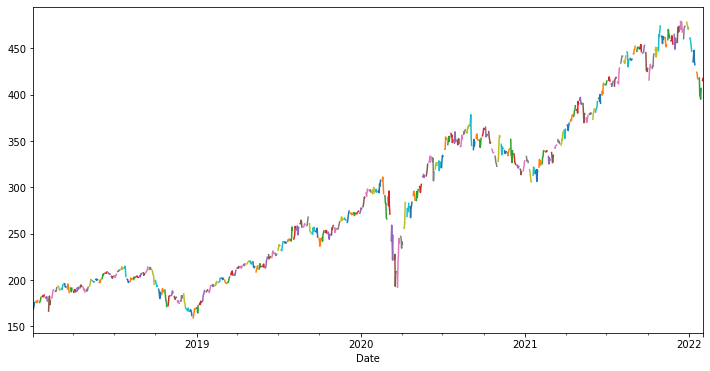

In [253]:
otg = test_data.resample('W')
otg.plot(figsize=(12,6))

Как можно заметить, новый график не имеет ярких выбросов и имеет ярко выраженный тренд. Из это можно сделать вывод о том, что ряд не является стационарным

<AxesSubplot:xlabel='Date'>

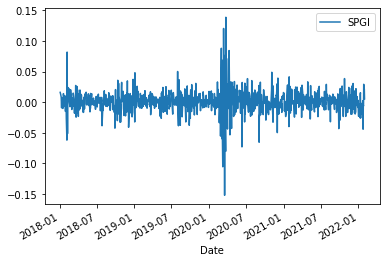

In [254]:
test_data = test_data.pct_change()[1:]
test_data.plot()

In [255]:
test_data.describe()

,SPGI
count,1028.000000
mean,0.001062
std,0.018787
min,-0.151893
25%,-0.006670
50%,0.001406
75%,0.009409
max,0.138558


проведем обобщенный тест Дикки-Фуллера на наличие единичных корней

In [256]:
test = sm.tsa.adfuller(test_data)
print('adf: ', test[0] )
print('p-value: ', round(test[1], 5))
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -8.79876804821265
p-value:  0.0
Critical values:  {'1%': -3.4368090295897624, '5%': -2.864391734279673, '10%': -2.5682883916134824}
единичных корней нет, ряд стационарен


Если бы ряд был не стационарен, то можно пробовать взятие разности рядовь.Если, например, первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.

In [257]:
#otg1diff = otg.diff(periods=1).dropna()

чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

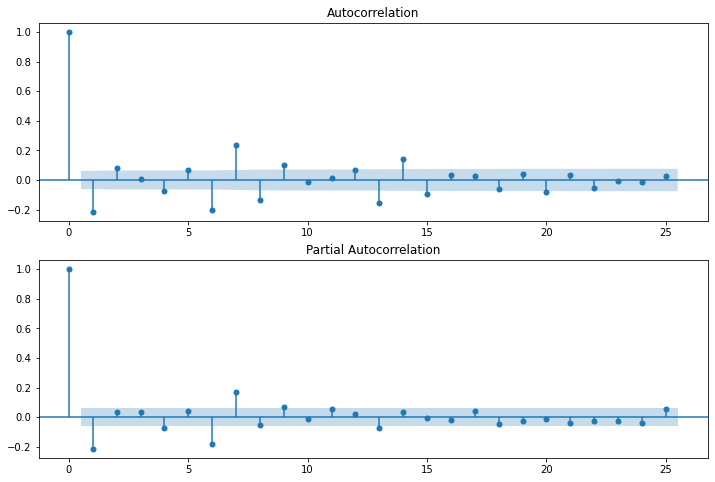

In [258]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(test_data.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(test_data, lags=25, ax=ax2)

In [259]:
test_data

,SPGI
Date,
2018-01-03,0.016060
2018-01-04,0.014987
2018-01-05,0.013381
2018-01-08,0.008423
2018-01-09,0.000339
...,...
2022-01-26,-0.004981
2022-01-27,-0.006188
2022-01-28,0.029209


In [260]:
d=0
p=3
q=3

mod = sm.tsa.arima.ARIMA(test_data.values, order=(p,d,q))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1028
Model:                 ARIMA(3, 0, 3)   Log Likelihood                2653.431
Date:                Tue, 10 May 2022   AIC                          -5290.861
Time:                        16:09:08   BIC                          -5251.378
Sample:                             0   HQIC                         -5275.875
                               - 1028                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.935      0.053   -1.38e-05       0.002
ar.L1         -0.1018      1.362     -0.075      0.940      -2.772       2.568
ar.L2          0.0015      1.297      0.001      0.9

In [261]:
result = res.summary()
type(result)

statsmodels.iolib.summary.Summary

In [262]:
res.params

array([ 0.00105554, -0.1017636 ,  0.00153054,  0.08556565, -0.10609165,
        0.06205051, -0.09433446,  0.0003352 ])

In [263]:
results = pd.DataFrame(data=[], columns=['const','ar.L1','ar.L2','ar.L3','ma.L1','ma.L2','ma.L3','sigma2' ])
results

,const,ar.L1,ar.L2,ar.L3,ma.L1,ma.L2,ma.L3,sigma2


In [264]:
import warnings
warnings.filterwarnings("ignore")

d=0
p=3
q=3


for asset in df.columns:
    data = df[asset]
    data = data.pct_change()[1:]
    # тест на стационарность
    test = sm.tsa.adfuller(data)

    if test[0]> test[4]['5%']: 
        print(asset + ': не стационарен')
    else:
        #print(asset + ': стационарен')
        mod = sm.tsa.arima.ARIMA(data.values, order=(p,d,q))
        res = mod.fit()
        results.loc[asset] = res.params
    

In [265]:
results

,const,ar.L1,ar.L2,ar.L3,ma.L1,ma.L2,ma.L3,sigma2
CERN,0.000403,-0.311176,-0.157265,-0.133275,0.276151,0.206141,0.156790,0.000254
IT,0.001077,-0.014005,0.046079,0.017908,-0.010942,0.051274,0.017351,0.000462
DPZ,0.001085,-0.050702,-0.047293,-0.147892,-0.075058,0.088174,0.211035,0.000409
EIX,0.000181,-0.092725,-0.031339,0.415691,0.026428,0.028826,-0.418826,0.000412
FFIV,0.000620,-0.023636,0.020692,0.014161,-0.023692,0.020482,0.014336,0.000381
...,...,...,...,...,...,...,...,...
ORLY,0.001051,-0.093521,-0.048387,0.018820,-0.041218,0.158503,-0.094062,0.000327
HPQ,0.001121,-0.452456,0.423387,0.522992,0.353232,-0.357523,-0.467440,0.000514
HON,0.000470,-0.016026,-0.029674,0.096019,-0.040899,0.084150,-0.123281,0.000301
TFX,0.000396,-0.327238,0.180360,-0.081520,0.254528,-0.135880,0.178453,0.000405


In [267]:
X_arima = results

# Pipeline

In [300]:
class AssetClustering:
    
    r_state = 42
    n_clusters = np.arange(9, 14)
    
    best_params_models = { 'KMeans': {'instance' : KMeans(random_state=r_state),
                              'params': {'algorithm': 'auto', 'init': 'k-means++', 'n_clusters': 11, 'n_init': 5}
                               }, #10
                           'AgglomerativeClustering': {'instance' : AgglomerativeClustering(),
                              'params': {'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 11} #9
                               },
                           'GaussianMixture': {'instance' : GaussianMixture(random_state=r_state),
                              'params': {'covariance_type': 'tied', 'init_params': 'kmeans', 'n_components': 11}
                               },
                           'AffinityPropagation': {'instance' : AffinityPropagation(random_state=r_state),
                              'params': {'affinity': 'euclidean', 'convergence_iter': 1, 'damping': 0.9}
                               },
                           'KernelKMeans':  {'instance' : KernelKMeans(random_state=r_state),
                              'params': {'n_clusters' : 11, 'kernel': 'gak', 'n_init' : 5}
                               },
                          'TimeSeriesKMeans':{'instance' : TimeSeriesKMeans(random_state=r_state),
                                              'params' : {'n_clusters' : 11, 'metric':'euclidean', 'max_iter':5}},
                          'KShape' : {'instance' : KShape(random_state=r_state),
                                              'params' : {'n_clusters':11, 'n_init':5}}
                         
                         }
    
    

    all_models = { 'KMeans': {'instance' : KMeans(random_state=r_state),
                              'params': {
                                   'n_clusters': n_clusters,
                                   'init': ['k-means++', 'random'], # choose initial states randomly or optimally?
                                   'algorithm':['auto', 'full'], # EM-style algorithm (full) or another?
                                   'n_init' : [5, 10, 15] # number of changing initial states to find optimal
                               }},
               
                   'AgglomerativeClustering': {'instance' : AgglomerativeClustering(),
                                               'params' : {
                           'n_clusters': n_clusters,
                           'affinity': ['euclidean', 'manhattan', 'cosine'], # affinity це близость, расстояние
                           'linkage': ['complete', 'average', 'single'] # way of calculating distance between clusters
                       }},
                   'GaussianMixture': {'instance' : GaussianMixture(random_state=r_state),
                                               'params' : {
                           'n_components': n_clusters,
                           'covariance_type':['full', 'tied', 'diag', 'spherical'],
                           'init_params': ['kmeans', 'random'] # used to initialize the weights, the means and the precisions.
                       }},
                   'KernelKMeans': {'instance' : KernelKMeans(random_state=r_state),
                                               'params' : {
                          'n_clusters': n_clusters,
                          'n_init' : [5, 10, 15,20]
                      }},
                   'TimeSeriesKMeans':{'instance' : TimeSeriesKMeans(random_state=r_state),
                                               'params' : {
                          'n_clusters': n_clusters,
                          'metric': ["euclidean", "softdtw", "dtw"],
                          'max_iter' :[5,10,15]
                      }},
                  'KShape': {'instance' : KShape(random_state=r_state),
                                               'params' : {
                         'n_clusters': n_clusters,
                          'n_init' : [5, 10, 15,20]   
                  }},
                  'AffinityPropagation': { 'instance' : AffinityPropagation(random_state=r_state),
                                          'params': 
              {
                  'damping' : [0.5, 0.75, 0.9], #is the extent to which the current value is maintained
                  'affinity': ['euclidean'],
                  'convergence_iter' : [1, 15, 20, 25]
              }}
              }
    
    def __init__(self, X: list, model: list, grid_search: bool, 
                 metrics=["calinski_harabasz", "davies_bouldin", 'homogenity'], ref_values=[]):
        self.X = X
        self.model = model
        self.grid_search = grid_search
        if len(ref_values) != 0:
            self.ref_values = ref_values
        else:
            if 'homogenity' in metrics:
                metrics.remove('homogenity')
        self.metrics = metrics
                
    
    
    def calculate_score(self,labels, metric):
    
        if metric == "davies_bouldin":
            score = davies_bouldin_score(self.X, labels)
        elif metric == "calinski_harabasz":
            score = calinski_harabasz_score(self.X, labels)
        elif metric == 'homogenity':
            score = homogeneity_score(self.ref_values, labels)
        else:
            score = "no such metric"     

        return score
    
    
    def train(self, model, model_name, params):
        best_score = 0
        best_grid = []

        if self.grid_search:
            for grid in ParameterGrid(params):

                model.set_params(**grid)
                if model_name in ['GaussianMixture', 'TimeSeriesKMeans', 'KShape', 'AffinityPropagation']:
                    labels = model.fit(self.X).predict(self.X)
                elif model_name == 'KernelKMeans':
                    print('klklklk')
                    labels = model.fit_predict(self.X)
                    print('sjkhsjjshfrf')
                else:
                    labels = model.fit(self.X).labels_
                score = silhouette_score(self.X,labels)

                if score > best_score:
                    best_score = score
                    best_grid = grid
        else:
            grid = self.best_params_models[model_name]['params']
            model.set_params(**grid)
            if model_name in ['GaussianMixture','TimeSeriesKMeans', 'KShape', 'AffinityPropagation']:
                labels = model.fit(self.X).predict(self.X)
            elif model_name == 'KernelKMeans':
                    print('klklklk')
                    labels = model.fit_predict(self.X)
                    print('sjkhsjjshfrf')
            else:
                labels = model.fit(self.X).labels_
            best_score = silhouette_score(self.X,labels)
            best_grid = grid

        return [best_grid, best_score], labels
    
    def main(self):
     
        # optimizing by silhouette_score by default
        # preparing results table where row is a model, column is metric (and hyperparams)
        result_cols = ['hyperparams','silhouette_score']
        if len(self.metrics) != 0:
            result_cols.extend(self.metrics)
        results = pd.DataFrame(data=[], columns=result_cols)

        for model_name in self.model:
            print(model_name)
            model = self.all_models[model_name]['instance']
            params = self.all_models[model_name]['params']

            # clustering
            res_array, labels = self.train(model, model_name, params)

            # getting metrics
            for metric in self.metrics:
                score = self.calculate_score(labels,metric)
                res_array.append(score)

            #assert(len(results.columns)==res_array)
            # formatting results
            results.loc[model_name] = res_array


        return results

In [313]:
results_pkl = {}

## FE #1: Табличные фичи

In [235]:
X_table_features = CalculatingStockFeatures.calculate_features(df, df_index['^GSPC'])

In [274]:
models_for_table = ['KMeans', 'AgglomerativeClustering', 'GaussianMixture', 'AffinityPropagation']

tableFeatures_res = AssetClustering(X_table_features.values, model=models_for_table, 
                                    grid_search=False, ref_values=df_predictions.original_n.values).main()
tableFeatures_res.sort_values('silhouette_score', ascending=False)

,hyperparams,silhouette_score,calinski_harabasz,davies_bouldin,homogenity
AgglomerativeClustering,"{'affinity': 'euclidean', 'linkage': 'complete...",0.645658,8678.791490,0.340421,0.051237
KMeans,"{'algorithm': 'auto', 'init': 'k-means++', 'n_...",0.575953,15735.058081,0.399761,0.078168
GaussianMixture,"{'covariance_type': 'tied', 'init_params': 'km...",0.554402,12005.122659,0.479213,0.064180
AffinityPropagation,"{'affinity': 'euclidean', 'convergence_iter': ...",0.519816,3303.171632,0.336810,0.044054


In [315]:
results_pkl['FE#1'] = {}
results_pkl['FE#1']['X'] = X_table_features.values
results_pkl['FE#1']['results'] = tableFeatures_res

## FE #2: Fourier transformation

In [275]:
models_for_fourie = ['KMeans', 'AgglomerativeClustering', 'GaussianMixture']

fourie_res1 = AssetClustering(X_fourie_1, model=models_for_fourie, grid_search=False,
                             ref_values=df_predictions.original_n.values).main()
fourie_res1.index = [ind + '_fourie1' for ind in fourie_res1.index]

fourie_res2 = AssetClustering(X_fourie_2, model=models_for_fourie, grid_search=False,
                              ref_values=df_predictions.original_n.values).main()
fourie_res2.index = [ind + '_fourie2' for ind in fourie_res2.index]

fourie_res = fourie_res1.append(fourie_res2)
fourie_res.sort_values('silhouette_score', ascending=False)

,hyperparams,silhouette_score,calinski_harabasz,davies_bouldin,homogenity
KMeans_fourie2,"{'algorithm': 'auto', 'init': 'k-means++', 'n_...",0.561626,4774.935262,0.426174,0.094813
AgglomerativeClustering_fourie2,"{'affinity': 'euclidean', 'linkage': 'complete...",0.559652,2172.805027,0.427789,0.055502
AgglomerativeClustering_fourie1,"{'affinity': 'euclidean', 'linkage': 'complete...",0.526998,2671.109013,0.391784,0.050151
KMeans_fourie1,"{'algorithm': 'auto', 'init': 'k-means++', 'n_...",0.456572,4295.932176,0.436713,0.062283
GaussianMixture_fourie1,"{'covariance_type': 'tied', 'init_params': 'km...",0.456572,4295.932176,0.436713,0.062283
GaussianMixture_fourie2,"{'covariance_type': 'tied', 'init_params': 'km...",0.392648,3540.372589,0.442871,0.086319


In [316]:
results_pkl['FE#2'] = {}
results_pkl['FE#2']['X'] = {"fourie1": X_fourie_1, "fourie2": X_fourie_2}
results_pkl['FE#2']['results'] = fourie_res

## FE #3: ARIMA

In [276]:
models_for_table = ['KMeans', 'AgglomerativeClustering', 'GaussianMixture', 'AffinityPropagation']

arima_res = AssetClustering(X_arima.values, model=models_for_table, grid_search=False,
                            ref_values=df_predictions.original_n.values).main()
arima_res.sort_values('silhouette_score', ascending=False)

,hyperparams,silhouette_score,calinski_harabasz,davies_bouldin,homogenity
AffinityPropagation,"{'affinity': 'euclidean', 'convergence_iter': ...",0.427242,152.382885,0.984655,0.012854
KMeans,"{'algorithm': 'auto', 'init': 'k-means++', 'n_...",0.402905,259.036873,0.865927,0.076524
GaussianMixture,"{'covariance_type': 'tied', 'init_params': 'km...",0.353095,190.981009,1.088842,0.097475
AgglomerativeClustering,"{'affinity': 'euclidean', 'linkage': 'complete...",0.290123,178.101590,0.874845,0.063227


In [317]:
results_pkl['FE#3'] = {}
results_pkl['FE#3']['X'] = X_arima.values
results_pkl['FE#3']['results'] = arima_res

## FE #4: None (time series models applying)

In [305]:
models_for_time = ['TimeSeriesKMeans', 'KShape']

ts_res = AssetClustering(df.T.values, model=models_for_time, grid_search=False,
                         ref_values=df_predictions.original_n.values).main()
ts_res.sort_values('silhouette_score', ascending=False)

TimeSeriesKMeans
KShape


,hyperparams,silhouette_score,calinski_harabasz,davies_bouldin,homogenity
TimeSeriesKMeans,"{'n_clusters': 11, 'metric': 'euclidean', 'max...",0.415977,2172.140883,0.726221,0.064655
KShape,"{'n_clusters': 11, 'n_init': 5}",-0.294356,4.060780,8.734609,0.122790


In [318]:
results_pkl['FE#4'] = {}
results_pkl['FE#4']['X'] = df.T.values
results_pkl['FE#4']['results'] = ts_res

In [322]:
with open('results.pickle', 'wb') as file:
    pickle.dump(results, file)

# Debug

In [306]:
models_for_time = ['KernelKMeans']

ts_res = AssetClustering(df.T.values, model=models_for_time, grid_search=False,
                         ref_values=df_predictions.original_n.values).main()
ts_res.sort_values('silhouette_score', ascending=False)

KernelKMeans
klklklk


KeyboardInterrupt: 

In [286]:
X = df.T.values

array([[ 68.56999969,  69.06999969,  69.01000214, ...,  91.38999939,
         91.19999695,  91.25      ],
       [124.84999847, 125.19000244, 127.30000305, ..., 287.6000061 ,
        293.89001465, 295.73999023],
       [186.94000244, 191.66000366, 197.28999329, ..., 441.01000977,
        454.6499939 , 458.29998779],
       ...,
       [147.32324219, 146.10601807, 148.08041382, ..., 201.99000549,
        204.47999573, 205.33999634],
       [254.72999573, 256.64001465, 254.00999451, ..., 299.8500061 ,
        310.19000244, 309.5       ],
       [ 42.04999924,  42.93000031,  43.58000183, ..., 145.41999817,
        152.13999939, 151.61000061]])

In [308]:
s = KernelKMeans()
s.set_params(**{'n_clusters' : 11, 'kernel': 'gak', 'n_init' : 5})
s.fit_predict(X)

array([ 0,  4,  6,  9,  4,  1,  0,  0,  4,  7,  8,  2,  3,  8,  2,  9,  2,
        1,  1,  0, 10,  6,  2,  3,  0,  9,  9, 10,  7, 10,  6,  2,  4,  6,
        1,  2,  7, 10,  3,  6,  9,  1,  4,  3, 10,  9,  4,  0,  2,  2,  7,
        5,  6,  0,  3, 10,  1,  0,  9,  0,  4,  5,  6,  0,  9,  8, 10,  5,
        2,  4,  3,  1,  6,  8,  2,  5,  5,  0,  9,  6,  1,  7,  2, 10,  7,
        8,  0,  9,  4,  2, 10,  9,  5,  0,  2,  0,  0,  1,  1,  8,  7,  6,
        5,  3,  9,  2,  6,  1,  7,  1, 10, 10,  4,  5,  1,  3, 10,  4,  5,
        3,  3,  2,  9,  7, 10,  2,  3,  5,  8,  4, 10,  5, 10,  3, 10, 10,
        8,  9,  3,  3,  1,  0,  0,  7,  7,  9,  5,  4,  1, 10,  6,  6,  9,
       10,  2, 10,  3,  1,  9,  4, 10,  5,  0,  6, 10,  1,  6,  8,  0,  7,
        4,  9,  4,  6,  0,  0,  6,  0,  0,  2,  8,  4, 10,  5,  8,  7,  4,
       10,  5,  9,  4,  8,  6,  6,  1,  1,  0,  0,  6,  4,  1,  8,  6,  4,
        5,  1,  3,  9,  4,  5,  6,  8,  0,  7,  0,  1,  9,  3,  4,  5,  3,
        8,  3,  3,  4,  2

In [311]:
metrics=["calinski_harabasz", "davies_bouldin", 'homogenity']
labels = s.fit_predict(X)
print(labels)
print(X)

def calculate_score(X,labels, metric):
    
        if metric == "davies_bouldin":
            score = davies_bouldin_score(X, labels)
        elif metric == "calinski_harabasz":
            score = calinski_harabasz_score(X, labels)
        elif metric == 'homogenity':
            score = homogeneity_score(ref_values, labels)
        else:
            score = "no such metric"     

for metric in metrics:
       print(calculate_score(X,labels,df_predictions.original_n.values))

[ 6  7  8  5  4 10  5  8  3  1  1  4  0 10  8 10 10  3  1  3  8  3  5  0
  1 10  6  1  5  9  8  0  5  3  5  0  9  3  2  1  4  1  5  9  3  6  5  0
  2  1  3  1  5  3  0  1  1  2  2  5  5 10  3  3 10  1  3  6  8  8  0  3
 10  2  6  9  0 10  1  8  2  1  8  2  2  9  3  3  8  5  9  8  1  4 10  8
  7  9  0  9  8 10  7  4  5  9  9  2  0  0  7  5  3 10  3  8  0  1 10 10
  7  3  6  7  8  7  8  5  6 10 10  9  7  8  5  6  8 10  7  5 10  3  9  3
 10  0  6  8  8  1  9  3  7  3  9  5  5  7  6  7  2  5  5  3  3  3  5  1
  7  2 10  6  8  8  7  0  6  9  5  9  2 10  5  4  1  4  5  3  4 10  8  5
  8  4  5  5  6  1  1 10  6  1  0  6  3  3  2  9  6  8  0  4  3 10  6  2
  9  6  8  6  9  1  0  6  8  9  7  3  6  9  2  5  6  9  4  3  5  8  7  7
  4  1 10  5  8  6  0  9  8 10  7 10  2 10  6 10  9  9 10  7  6  3  1  2
  3  3  5  4 10  1  3  9  7  4  5  0  1  4  0  4  8  2  0  8  5  5  5  9
  2 10  3  7  5  9  6  2  2 10  4  5  1  9  3  6  3  2  2  2  3  8  8  4
  5 10  3  2  1  5  7  2  2  5  4  1  6  1  6  5  9